Ce Notebook permet d'explorer SurvTreeSHAP(t) et les méthodes qui lui sont associées.
Il utilise les données METABRIC disponibles sur https://www.kaggle.com/datasets/raghadalharbi/breast-cancer-gene-expression-profiles-metabric et reproduit les résultats de notre rapport.

Le chargement de certaines cellules peut demander un certain temps. En python 3.10.12 ce Notebook se lance normalement sans souci.

# Packages

Nous utilisons quelques packages moins courants

In [1]:
! pip install lifelines scikit-survival survshap shap jinja2 survinsights seaborn numba

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 11.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 49.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.9 MB/s eta 0:00:00
  DEPRECATION: Building 'autograd-gamma' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'autograd-gamma'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.wh

Nous importons des packages de base que nous utiliserons dans ce Notebook

fonctions_SurvTreeShap contient notre objet qui permet d' utiliser SurvTreeSHAP

In [2]:
# manipulations de base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# packages de survie
from sksurv.util import Surv
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import integrated_brier_score
from sksurv.metrics import concordance_index_censored
from lifelines import CoxPHFitter
from survshap import SurvivalModelExplainer, PredictSurvSHAP

# Manipulation des données
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#Notre objet et ses méthodes
import fonctions_SurvTreeShap as fstp

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import importlib
importlib.reload(fstp)

<module 'fonctions_SurvTreeShap' from '/home/onyxia/Surv-ML/SurvTreeSHAP_Python/fonctions_SurvTreeShap.py'>

# Données

Nous commençons par charger nos données

In [4]:
data = pd.read_csv("METABRIC_RNA_Mutation.csv")
data.head(3)

/tmp/ipykernel_6426/3417808307.py:1: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("METABRIC_RNA_Mutation.csv")


,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0


Nous retraitons les données pour éviter différents problèmes

In [5]:
colones_00 = data.columns[520:]  # colones dont on veut faire passer 0 à "0", a partir de la colone "pik3ca_mut"
data[colones_00] = data[colones_00].astype(str) 
data[colones_00] = data[colones_00].applymap(lambda x: 0 if x == "0" else 1) # 0 indique qu'il n'y a pas de mutation, 1 indique qu'il y a une mutation

/tmp/ipykernel_6426/3687261148.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data[colones_00] = data[colones_00].applymap(lambda x: 0 if x == "0" else 1) # 0 indique qu'il n'y a pas de mutation, 1 indique qu'il y a une mutation


In [6]:
for col in data.select_dtypes(include=['object']).columns:
    data[col] = LabelEncoder().fit_transform(data[col])

On récupère nos données de survie

In [7]:
y = data[["death_from_cancer", "overall_survival_months"]]
y['Died_of_Desease'] = (y['death_from_cancer'] == 0).astype(int) # on considère que censure = autres morts + sorties de l'étude
y=y.drop("death_from_cancer", axis=1)
y.head(3)

/tmp/ipykernel_6426/4192884101.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Died_of_Desease'] = (y['death_from_cancer'] == 0).astype(int) # on considère que censure = autres morts + sorties de l'étude


,overall_survival_months,Died_of_Desease
0,140.500000,0
1,84.633333,0
2,163.700000,1


In [8]:
X = data.drop(columns=["death_from_cancer", "overall_survival_months", "overall_survival"]) # on enlève les données de survie de X
X.head(3)

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,1,0,1,3,0,6,1.0,1,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,0,0,1,0,0,2,1.0,1,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,1,0,1,0,1,3,1.0,1,...,0,0,0,0,0,0,0,0,0,0


# Dataset entier

Dans un premier temps, nous cherchons juste à utiliser notre méthode sur le data-set entier

## RSF

Il faut repréparer un petit peu nos données

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # séparation entraînement - test
y_train_RSF = Surv.from_dataframe("Died_of_Desease", "overall_survival_months", y_train) #transformation au format de survie
y_test_RSF = Surv.from_dataframe("Died_of_Desease", "overall_survival_months", y_test) #transformation au format de survie

On entraîne une RSF sur nos données

In [10]:
rsf = RandomSurvivalForest(n_estimators=100, random_state=42, max_depth=3)
rsf.fit(X_train, y_train_RSF)

RandomSurvivalForest(max_depth=3, random_state=42)

## Performance

On mesure les performance de notre modèle grâce au Brier-Score et au C-index.

In [11]:
times = np.arange(2, 337) #points d'évaluation du BS
survs = rsf.predict_survival_function(X_test) #on réalise nos prédictions

preds = np.asarray([[fn(t) for t in times] for fn in survs])
score = integrated_brier_score(y_train_RSF, y_test_RSF, preds, times)
print("l'IBS du modèle vaut: ", score)

l'IBS du modèle vaut:  0.17259456392030215


In [12]:
y_pred_rsf = rsf.predict(X_test)
c_index = concordance_index_censored(y_test_RSF["Died_of_Desease"], y_test_RSF["overall_survival_months"], y_pred_rsf)[0]
print("le C-index du modèle vaut: ", c_index)

le C-index du modèle vaut:  0.7271034563016409


Ce sont des performances plutôt satisfaisantes

## SurvTreeSHAP(t)

On peut calculer SurvSHAP(t) grâce à notre méthode.

Ici, nous utilisons les critères selection="area", min=10 et max=10, pour ne représenter que les 10 variables les plus contributives positivement et les 10 variables les plus contributives négativemement au sens de l'aire sous la courbe. 

Pour avoir selon celles qui ont le plus grand minimum ou le plus grand maximum, on peut choisir selection="minmax". 

Si on veut voir toutes les valeurs, on peut laisser selection=None, mais ce n'est pas forcément très facile à comprendre...

100%|██████████| 1374/1374 [00:05<00:00, 239.67it/s]


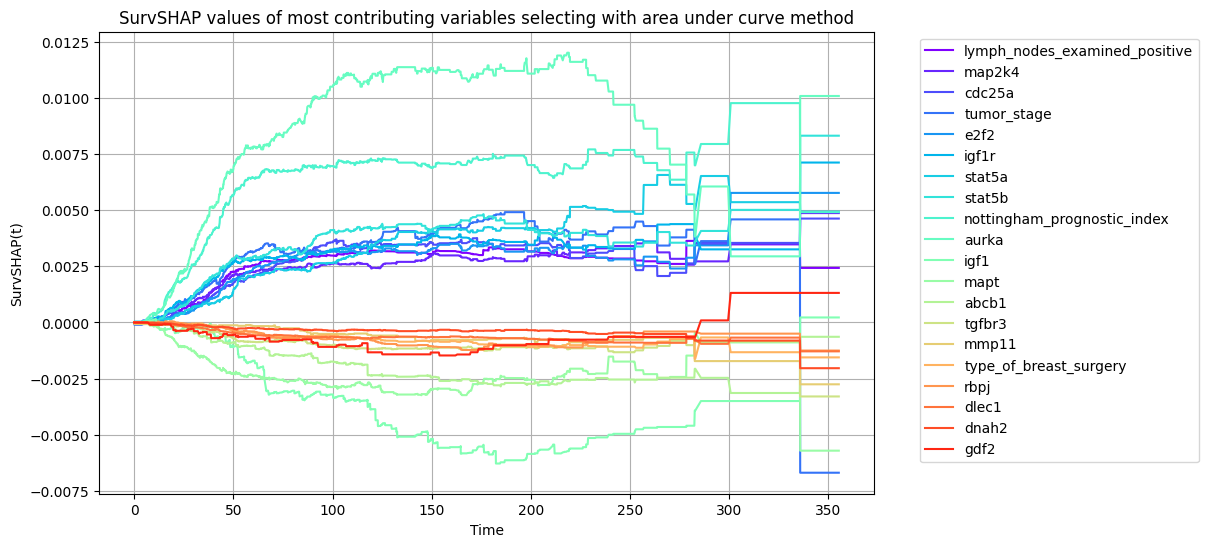

In [13]:
patient = 0
STS=fstp.SurvTreeSHAPexplainer(rsf, X_test)
STS.plotgraph(n=patient, selection="area", min=10, max=10)

On voit que l'indexe de Nottingham est très contributif à l'explication de la survie. C'est une excellente nouvelle puisque c'est un outil très utilisé par les médecins pour estimer les chances de survie de leurs patientes. 

On peut ensuite reagrder ce que vaut la moyenne de l'aire sous la courbe des variables les plus contributives pour les premiers individus.
En rouge nous avons l'aire sous la courbe négative moyenne, en vert, l'aire sous la courbe positive moyenne. La somme des deux permet de retrouver les variables plus contributives au sens de l'aire sous la courbe de la valeur absolue de SurvSHAP.

100%|██████████| 1374/1374 [00:02<00:00, 465.09it/s]
/home/onyxia/Surv-ML/SurvTreeSHAP_Python/fonctions_SurvTreeShap.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


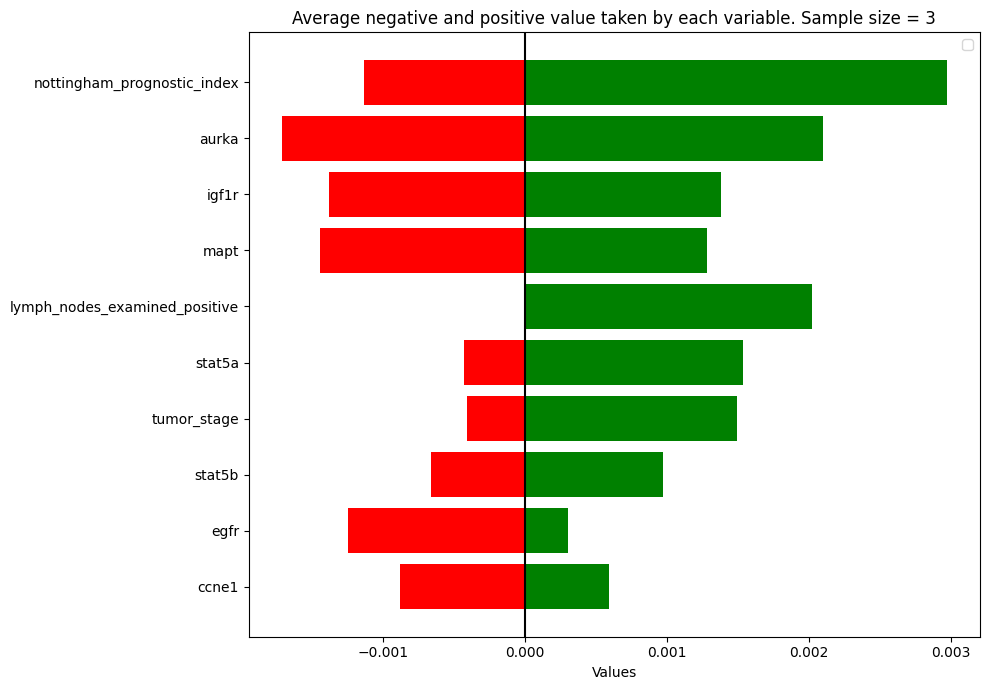

In [14]:
STS.averagesurvshap(3, 10)

On retrouve la même bonne nouvelle que tout à l'heure avec une bonne capcité prédictrice de l'index de Notthingam pour ces trois premiers patients.

# Comutation PIK3CA-TP53 et comparaison à un modèle de COX

On s'intéresse désormais à l'association entre la comutation des gènes TP53 et PIK3CA et une plus faible survie décrite entre autres dans "Concomitant PIK3CA and TP53 Mutations in Breast Cancer: An Analysis of Clinicopathologic and Mutational Features, Neoadjuvant Therapeutic Response, and Prognosis" par Lin et al. en 2023 (cf. https://pmc.ncbi.nlm.nih.gov/articles/PMC10475711/).

Nous cherchons en particulier à reproduire leur jeu de données et à trouver des résultats similaires grâce à SurvTreeSHAP(t).

## Préparation des données

On ne garde que les variables utilisées par Lin et al. On crée donc de nouveaux data-frames et retraitons les données. Les étapes sont les mêmes que précédemment. 

In [15]:
data_comp= data
X_comp= data_comp[["age_at_diagnosis", "tumor_stage", 'er_status', "her2_status", "pik3ca_mut", "tp53_mut"]] #seules variables que l'on garde pour x
#indicatrices des mutations
X_comp['comutation'] = ((X_comp['pik3ca_mut'] == 1) & (X_comp['tp53_mut'] == 1)).astype(int) 
X_comp['pik3ca_mut_only'] = ((X_comp['pik3ca_mut'] == 1) & (X_comp['tp53_mut'] == 0)).astype(int)
X_comp['tp53_mut_only'] = ((X_comp['tp53_mut'] == 1) & (X_comp['pik3ca_mut'] == 0)).astype(int)
#création de tumor stage NAN et traitement de tumor_stage
nan_ilocs = np.where(X_comp['tumor_stage'].isna())[0]
X_comp['tumor_stage_NAN'] = (X_comp['tumor_stage'].isna()).astype(int) 
X_comp = pd.get_dummies(X_comp, columns=['tumor_stage']).astype(float)
X_comp = X_comp.drop(columns=['pik3ca_mut', "tp53_mut", 'tumor_stage_0.0'])
X_comp.head(3)

/tmp/ipykernel_6426/3326595606.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_comp['comutation'] = ((X_comp['pik3ca_mut'] == 1) & (X_comp['tp53_mut'] == 1)).astype(int)
/tmp/ipykernel_6426/3326595606.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_comp['pik3ca_mut_only'] = ((X_comp['pik3ca_mut'] == 1) & (X_comp['tp53_mut'] == 0)).astype(int)
/tmp/ipykernel_6426/3326595606.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

,age_at_diagnosis,er_status,her2_status,comutation,pik3ca_mut_only,tp53_mut_only,tumor_stage_NAN,tumor_stage_1.0,tumor_stage_2.0,tumor_stage_3.0,tumor_stage_4.0
0,75.65,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,43.19,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,48.87,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [16]:
y_comp = data_comp[["death_from_cancer", "overall_survival_months"]]
y_comp['Died_of_Desease'] = (y_comp['death_from_cancer'] == 0).astype(int)
y_comp=y_comp.drop("death_from_cancer", axis=1)
y_comp.head(3)

/tmp/ipykernel_6426/406694114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_comp['Died_of_Desease'] = (y_comp['death_from_cancer'] == 0).astype(int)


,overall_survival_months,Died_of_Desease
0,140.500000,0
1,84.633333,0
2,163.700000,1


In [17]:
X_comp_train, X_comp_test, y_comp_train, y_comp_test = train_test_split(X_comp, y_comp, test_size=0.2, random_state=42)
y_comp_train_RSF = Surv.from_dataframe("Died_of_Desease", "overall_survival_months", y_comp_train)
y_comp_test_RSF = Surv.from_dataframe("Died_of_Desease", "overall_survival_months", y_comp_test)

In [18]:
comutés = X_comp_test[X_comp_test["comutation"] == 1] #si l'on veut accéder à un sous-échantillon avec que des comutés

## Comparaison des modèles

### Modèle de Cox

Nous recréons le modèle de Cox du papier

In [19]:
data_for_cox= pd.concat([X_comp_train, y_comp_train], axis=1)
cph = CoxPHFitter()
cph.fit(data_for_cox, duration_col='overall_survival_months', event_col='Died_of_Desease')

# Résumé du modèle
cph.print_summary()

/usr/local/lib/python3.12/site-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.828. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?

  warnings.warn(


<lifelines.CoxPHFitter: fitted with 1523 total observations, 1029 right-censored observations>
             duration col = 'overall_survival_months'
                event col = 'Died_of_Desease'
      baseline estimation = breslow
   number of observations = 1523
number of events observed = 494
   partial log-likelihood = -3292.84
         time fit was run = 2025-05-16 09:09:15 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
age_at_diagnosis  0.01      1.01      0.00            0.00            0.02                1.00                1.02
er_status        -0.24      0.79      0.13           -0.49            0.01                0.61                1.01
her2_status       0.44      1.55      0.13            0.19            0.69                1.21                1.99
comutation        0.76      2.14      0.14            0.48            1.04                1.61                2.84
pik3ca_mut_only   0.02      1.02      0.12           -0.22            0.26                0.81                1.29
tp53_mut_only     0.17      1.19      0.14           -0.10            0.44                0.90                1.56
tumor_stage_NAN  13.26  5.75e+05    726.96        -1411.55         1438.07                0.00                 inf
tumor_stage_1.0  12.78  3.55e+05    726.96        -1412.03         1437.59                0.00                 inf
tumor_stage_2.0  13.44  6.89e+05    726.96        -1411.37         1438.25                0.00                 inf
tumor_stage_3.0  14.16  1.41e+06    726.96        -1410.65         1438.97                0.00                 inf
tumor_stage_4.0  14.78  2.62e+06    726.96        -1410.03         1439.59                0.00                 inf

                  cmp to     z      p  -log2(p)
covariate                                      
age_at_diagnosis    0.00  2.71   0.01      7.23
er_status           0.00 -1.87   0.06      4.03
her2_status         0.00  3.43 <0.005     10.72
comutation          0.00  5.27 <0.005     22.81
pik3ca_mut_only     0.00  0.18   0.86      0.22
tp53_mut_only       0.00  1.23   0.22      2.20
tumor_stage_NAN     0.00  0.02   0.99      0.02
tumor_stage_1.0     0.00  0.02   0.99      0.02
tumor_stage_2.0     0.00  0.02   0.99      0.02
tumor_stage_3.0     0.00  0.02   0.98      0.02
tumor_stage_4.0     0.00  0.02   0.98      0.02
---
Concordance = 0.67
Partial AIC = 6607.67
log-likelihood ratio test = 151.91 on 11 df
-log2(p) of ll-ratio test = 87.09

In [20]:
y_comp_pred_cox = cph.predict_partial_hazard(X_comp_test)
c_index_cox = concordance_index_censored(y_comp_test_RSF["Died_of_Desease"], y_comp_test_RSF["overall_survival_months"], y_comp_pred_cox)[0]
print("le C-Index du modèle de Cox vaut:", c_index_cox)

le C-Index du modèle de Cox vaut: 0.6638252065634819


In [21]:
times = np.arange(2, 337)
surv_pred_cox = cph.predict_survival_function(X_comp_test, times=times).T.to_numpy()  
score_cox = integrated_brier_score(y_comp_train_RSF, y_comp_test_RSF, surv_pred_cox, times)
print("l'IBS' du modèle de Cox vaut:", score_cox)

l'IBS' du modèle de Cox vaut: 0.16517816449649864


### Modèle RSF

On entraîne une nouvelle RSF sur ces mêmes données.

In [22]:
rsf_comp = RandomSurvivalForest(n_estimators=100, random_state=42, max_depth=3)
rsf_comp.fit(X_comp_train, y_comp_train_RSF)

RandomSurvivalForest(max_depth=3, random_state=42)

In [23]:
y_comp_pred_rsf = rsf_comp.predict(X_comp_test)
c_index_rsf = concordance_index_censored(y_comp_test_RSF["Died_of_Desease"], y_comp_test_RSF["overall_survival_months"], y_comp_pred_rsf)[0]
print("le C-Index de la RSF vaut:", c_index_cox)

le C-Index de la RSF vaut: 0.6638252065634819


In [24]:
surv_func_pred_rsf = rsf_comp.predict_survival_function(X_comp_test)
preds = np.asarray([[fn(t) for t in times] for fn in surv_func_pred_rsf])
score = integrated_brier_score(y_comp_train_RSF, y_comp_test_RSF, preds, times)
print("l'IBS de la RSF vaut:", score)

l'IBS de la RSF vaut: 0.17511345421112126


On a des C-Index et des IBS proches pour les deux modèles, donc interpréter notre RSF à un sens

## L'importance de la comutation pour la RSF

### Comparaison de SurvTreeSHAP et KernelSurvSHAP

On montre d'abord qu'on obtient un résultat très proche avec SurvTreeSHAP(t). À vrai dire, c'est plutôt Kernel SurvSHAP(t) qui est proche de notre algorithme puisqu'il approche les résultats.

Pour une patiente comuté on a:

100%|██████████| 1374/1374 [00:03<00:00, 385.07it/s]


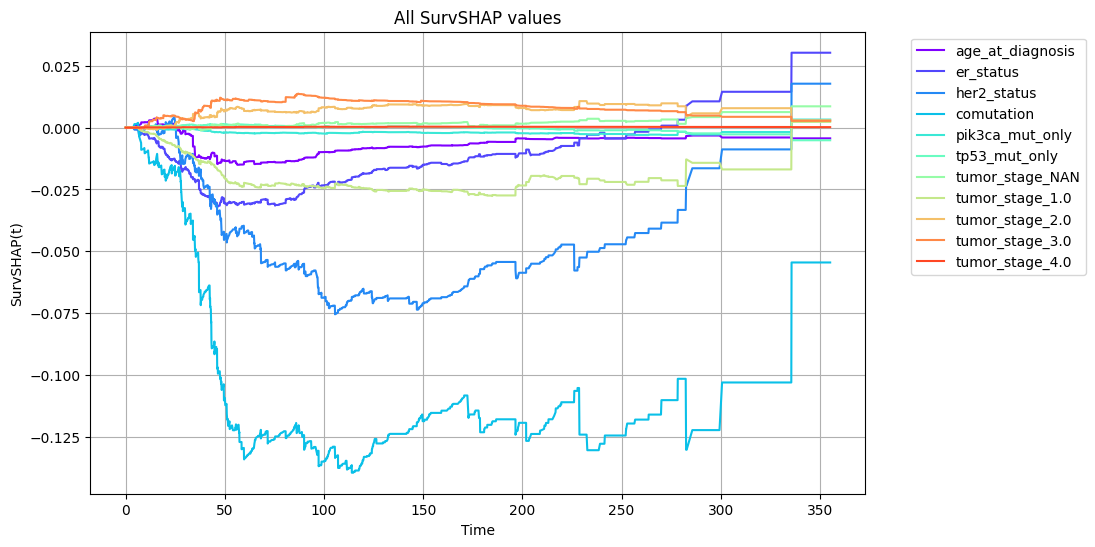

In [25]:
# SurvTreeSHAP

STS_comute= fstp.SurvTreeSHAPexplainer(rsf_comp, comutés)
STS_comute.plotgraph(2)

In [26]:
#ce code utilise KernelSHAP pour calculer SurvSHAP.
#Il prend une vingtaine de minutes à tourner.
#Pour le faire tourner, remplacer False par True

if False:
    # create explainer
    explainer = SurvivalModelExplainer(model = rsf_comp, data = X_comp_train, y = y_comp_train_RSF)

    # compute SHAP values for a single instance
    observation_A = comutés.iloc[[2]]
    survshap_A = PredictSurvSHAP()
    survshap_A.fit(explainer = explainer, new_observation = observation_A)

    df=survshap_A.result 

    # On sélectionne les colonnes temporelles (celles qui commencent par "t =")
    time_cols = [col for col in df.columns if col.startswith("t =")]

    # On convertit ces colonnes en float pour les trier correctement
    time_values = [float(col.replace("t = ", "")) for col in time_cols]

    # Tracé
    plt.figure(figsize=(12, 6))

    for i, row in df.iterrows():
        contribs = row[time_cols].values.astype(float)
        plt.plot(time_values, contribs, label=row["variable_name"])

    plt.xlabel("Time")
    plt.ylabel("SurvSHAP(t)")
    plt.title("All SurvSHAP values")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(True)
    plt.show()


On voit clairement que la variable comutation est très explicative.

On peut aussi représenter la survie moyenne à laquelle s'ajoute les contributions

 12%|█▏        | 162/1374 [00:00<00:03, 384.01it/s]

100%|██████████| 1374/1374 [00:03<00:00, 408.07it/s]


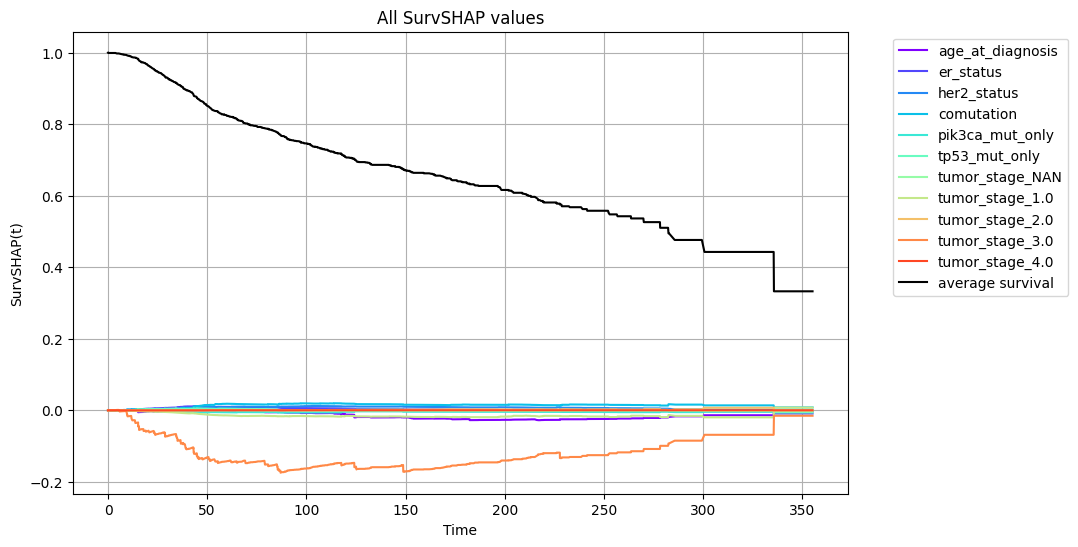

In [27]:
STS_comp= fstp.SurvTreeSHAPexplainer(rsf_comp, X_comp_test)
STS_comp.plotgraph(21,plot_average_surv=True)

### Classement des variables

Le classement des variables fait appraître la comutation comme l'une des variables les plus explicatives

100%|██████████| 1374/1374 [00:03<00:00, 435.39it/s]
/home/onyxia/Surv-ML/SurvTreeSHAP_Python/fonctions_SurvTreeShap.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


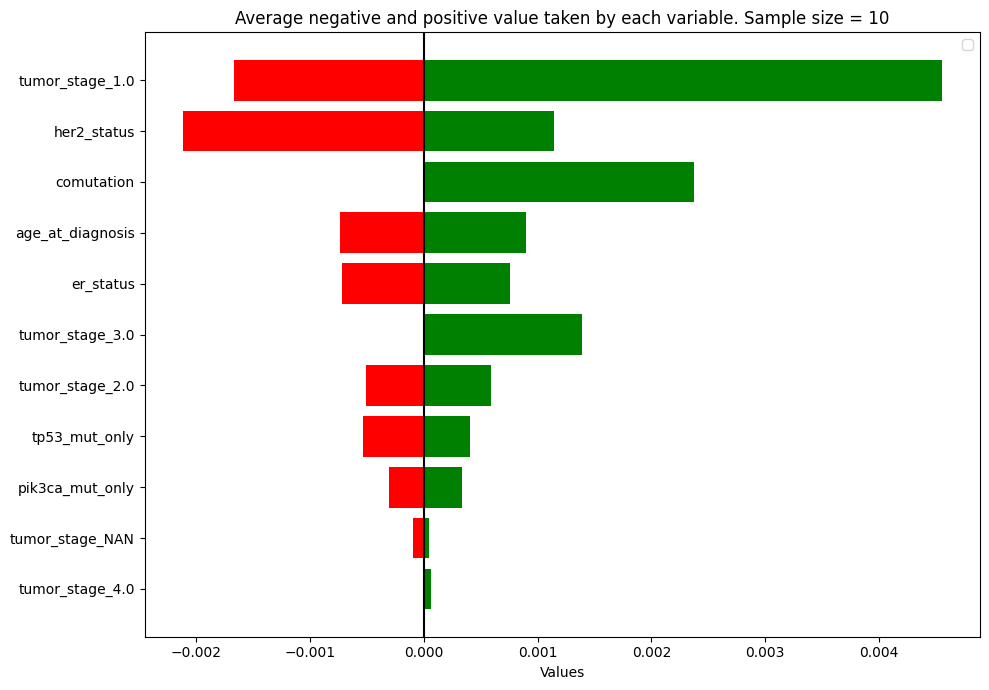

In [28]:
STS_comp.averagesurvshap(10)

Enfin, on peut regarder pour plusieurs patients, l'ordre d'importante des variables selon l'aire sous la courbe.

100%|██████████| 1374/1374 [00:03<00:00, 416.40it/s]


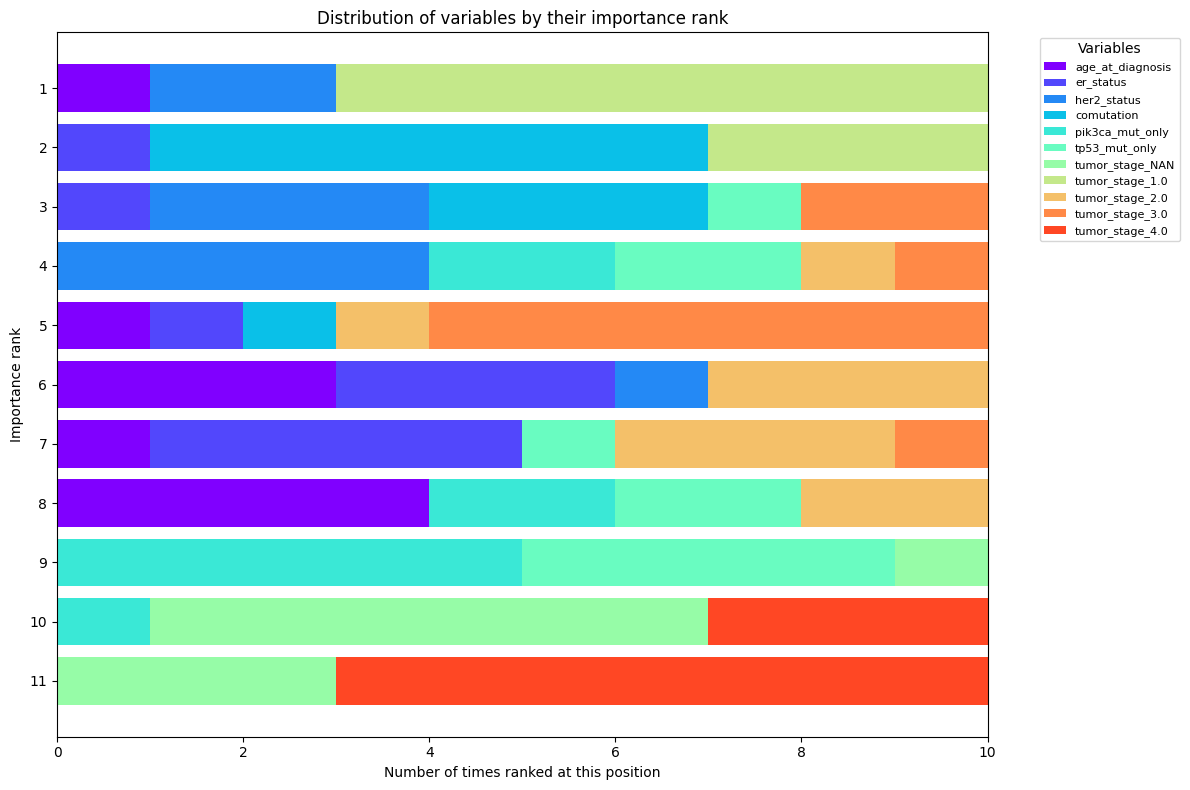

In [29]:
STS_comp.rankvariables(10)

La comutation est le plus souvent la deuxième ou la troisième variable la plus explicative